In [54]:
# from bdd_utils import *
import matplotlib.pyplot as plt
import argparse
import os
from os import path
import string
import sys
import zipfile

from cv2 import imread, imwrite
import keras.backend as K
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras.layers import Activation, BatchNormalization, Conv2D, \
    GlobalAveragePooling2D, MaxPooling2D, Dense, Input, add
from keras.layers import Conv2DTranspose, ReLU, Lambda, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.utils import Sequence, plot_model
import numpy as np

from ats.core import attention_sampling
from ats.utils.layers import L2Normalize, ResizeImages, SampleSoftmax, \
    ImageLinearTransform, ImagePan
from ats.utils.regularizers import multinomial_entropy
from ats.utils.training import Batcher

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from tensorflow import ConfigProto
from tensorflow import InteractiveSession
from tensorflow.python import debug as tf_debug
from keras.callbacks import TensorBoard
from bdd_utils import *
from keras_resnet import models as resnet_models

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
sess = K.get_session()
sess = tf_debug.LocalCLIDebugWrapperSession(sess)
K.set_session(sess)

In [55]:
def neighPatches(samples, patch_size, image):
    lt = [0, 0]
    lt[0] = max(samples[0] - patch_size[0], 0)
    lt[1] = max(samples[1] - patch_size[1], 0)
    rb = [0, 0]
    rb[0] = min(samples[0] + 2*patch_size[0], image.shape[0])
    rb[1] = min(samples[1] + 2*patch_size[1], image.shape[1])
    # print("lr: ", lt)
    # print("rb: ", rb)
    crop_img = image[lt[0]:rb[0], lt[1]:rb[1]]
    return crop_img, lt, rb

(1280, 1920, 3)


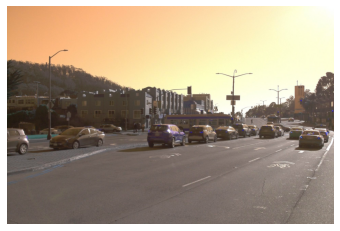

In [56]:
path = '/home/sc/Documents/scene-cache/data/waymo_kitti/kitti_00000/image_0'
# path = '/home/pyhuang/UM/data/kitti/image_0/'
f = 420
input_image = imread(path + str(f).zfill(15) + '.jpg')
print(input_image.shape)
resize_w = input_image.shape[1]
resize_h = input_image.shape[0]
plt.imshow(input_image)
plt.axis('off')
plt.show()
input_image = np.expand_dims(input_image, axis=0)

In [57]:
class options:
    def __init__(self, scale = 0.3, n_patches = 5, patch_size = (100, 100), regularizers_strength = 0.0001, load_dir = "/home/pyhuang/attention/kitti_detection/", resume = True, load_epoch = 100, batch_size = 32, epochs = 500, momentum = 0.9, clipnorm = 1, lr = 0.001, optimizer = "adam", classes = []):
        self.scale = scale
        self.n_patches = n_patches
        self.patch_size = patch_size
        self.regularizers_strength = regularizers_strength
        self.load_dir = load_dir
        self.resume = resume
        self.load_epoch = load_epoch
        self.batch_size = batch_size
        self.epochs = epochs
        self.momentum = momentum
        self.clipnorm = clipnorm
        self.lr = lr
        self.optimizer = optimizer
        self.classes = classes

In [58]:
# attention_sampling model
opts = options(
    scale = 0.3,
    n_patches = 6,
    patch_size = (100, 100),
    regularizers_strength = 0.0001,
    load_dir = "../../model_weights/bdd100k",
    resume = True,
    load_epoch = 500,
    batch_size = 32,
    epochs = 500,
    momentum = 0.9,
    clipnorm = 1,
    lr = 0.001,
    optimizer = "adam",
    classes = ['empty', 'car']
)

In [59]:
def attention(x):
    params = dict(
        activation="relu",
        padding="valid",
        kernel_regularizer=l2(1e-5)
    )
    x = Conv2D(8, kernel_size=3, **params)(x)
    x = Conv2D(16, kernel_size=3, **params)(x)
    x = Conv2D(32, kernel_size=3, **params)(x)
    x = Conv2D(1, kernel_size=3)(x)
    x = MaxPooling2D(pool_size=8)(x)
    x = SampleSoftmax(squeeze_channels=True, smooth=1e-4)(x)

    return x

def resnet(x, strides=[1, 2, 2, 2], filters=[32, 32, 32, 32]):
    """Implement a simple resnet."""
    # Do a convolution on x
    def c(x, filters, kernel, strides):
        return Conv2D(filters, kernel_size=kernel, strides=strides,
                      padding="same", use_bias=False)(x)

    # Do a BatchNorm on x
    def b(x):
        return BatchNormalization()(x)

    # Obviosuly just do relu
    def relu(x):
        return Activation("relu")(x)

    # Implement a resnet block. short is True when we need to add a convolution
    # for the shortcut
    def block(x, filters, strides, short):
        x = b(x)
        x = relu(x)
        x_short = x
        if short:
            x_short = c(x, filters, 1, strides)
        x = c(x, filters, 3, strides)
        x = b(x)
        x = relu(x)
        x = c(x, filters, 3, 1)
        x = add([x, x_short])

        return x

    # Implement the resnet
    stride_prev = strides.pop(0)
    filters_prev = filters.pop(0)
    y = c(x, filters_prev, 3, stride_prev)
    for s, f in zip(strides, filters):
        y = block(y, f, s, s != 1 or f != filters_prev)
        stride_prev = s
        filters_prev = f
    y = b(y)
    y = relu(y)

    # Average the final features and normalize them
    y = GlobalAveragePooling2D()(y)
    y = L2Normalize()(y)

    return y
    
def get_model(outputs, width, height, scale, n_patches, patch_size, reg):
    x_in = Input(shape=(height, width, 3))
    x_high = ImageLinearTransform()(x_in)
    x_high = ImagePan(horizontally=True, vertically=True)(x_high)
    x_low = ResizeImages((int(height*scale), int(width*scale)))(x_high)

    features, att, patches = attention_sampling(
        attention,
        resnet,
        patch_size,
        n_patches,
        replace=False,
        attention_regularizer=multinomial_entropy(reg),
        receptive_field=9
    )([x_low, x_high])
    y = Dense(outputs, activation="softmax")(features)

    # see a resnet18 for such image patch
    #image_input = Input(shape=(None, None, 3))
    # resnet18 = resnet_models.ResNet18(x_low, include_top=False, freeze_bn=True)
    # C5 = resnet18.outputs[-1]
    # drop_x = Dropout(rate=0.5)(C5)

    return (
        Model(inputs=x_in, outputs=[y]),
        Model(inputs=x_in, outputs=[att, patches, x_low])
        # Model(inputs=x_in, outputs=[drop_x])
    )

In [60]:
model, att_model, res18_model = get_model(
    len(opts.classes),
    resize_w, resize_h, 
    opts.scale,
    opts.n_patches,
    opts.patch_size,
    opts.regularizers_strength
)
print(model.summary())

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_6:0", shape=(?, 1280, 1920, 3), dtype=float32) at layer "input_6". The following previous layers were accessed without issue: []

In [ ]:
print(res18_model.summary())

In [43]:
if opts.resume:
    load_path = os.path.join(opts.load_dir, "weights." + str(opts.load_epoch) + ".h5")
    model.load_weights(load_path)
    model.trainable = False
    model.compile(
        loss="categorical_crossentropy",
        optimizer=get_optimizer(opts),
        metrics=["accuracy", "categorical_crossentropy"]
    )

In [44]:
x_low = model.layers[3].output
samples = model.layers[11].output
ats_map = model.layers[10].output
patch_features = model.layers[-3].output
expected_feature = model.layers[-2].output
ats_model = Model(model.input, [x_low, samples[0], samples[1], samples[2], ats_map, patch_features, expected_feature, model.output])

In [45]:
def show_patches(patches, size):
    row, col = size
    figs, axs = plt.subplots(row, col)
    for i in range(len(patches)):
        r = i // col
        c = i % col
        axs[r, c].imshow(patches[i])
        axs[r, c].axis("off")
    # axs[0, 0].imshow(patches[0, 0])
    # axs[2, 2].imshow(image)
    # axs[2, 2].axis("off")
    plt.show()
    plt.clf()
    plt.close()

420 : (1280, 1920, 3)


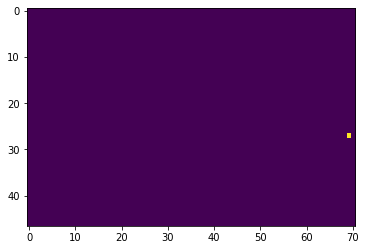

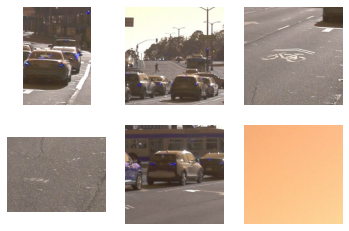

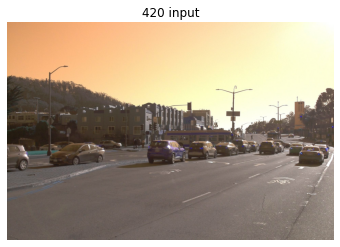

421 : (1280, 1920, 3)


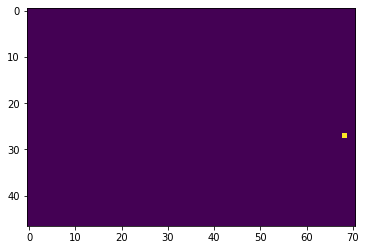

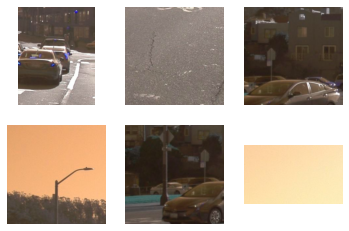

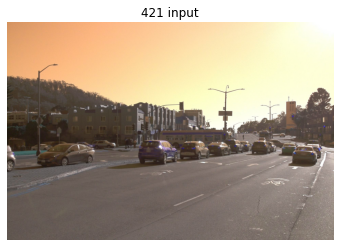

422 : (1280, 1920, 3)


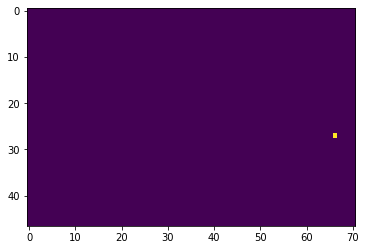

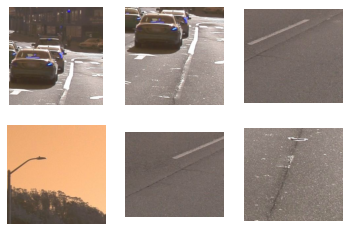

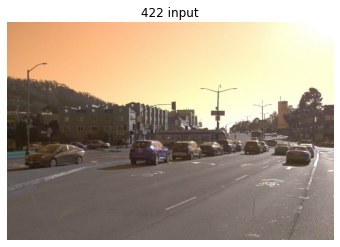

423 : (1280, 1920, 3)


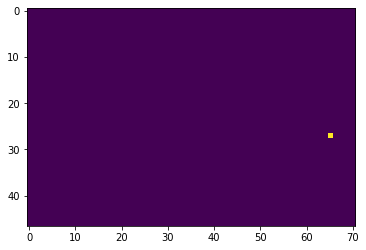

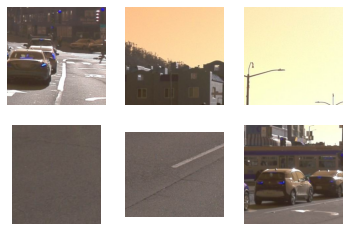

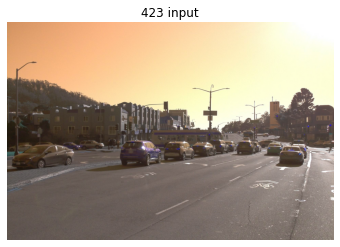

424 : (1280, 1920, 3)


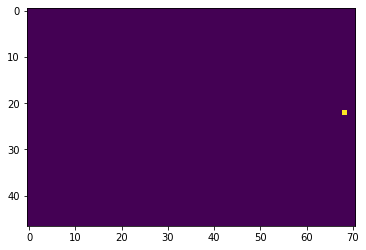

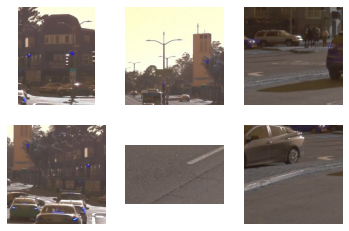

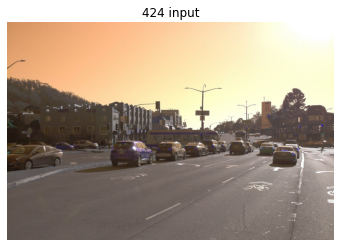

425 : (1280, 1920, 3)


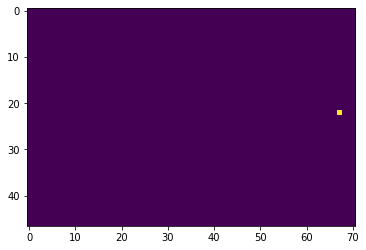

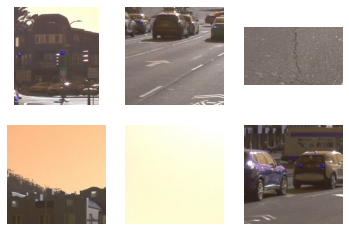

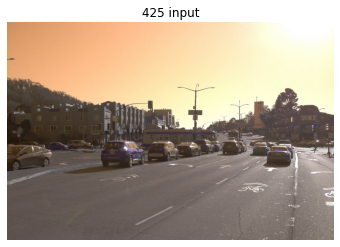

426 : (1280, 1920, 3)


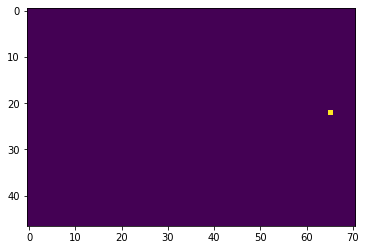

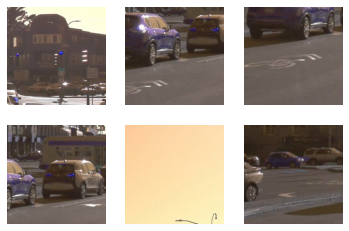

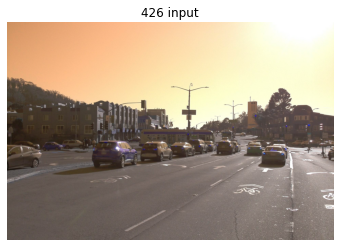

427 : (1280, 1920, 3)


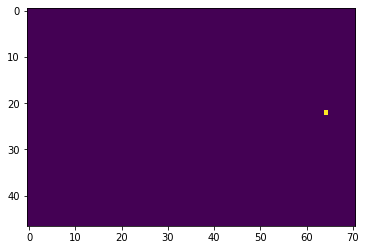

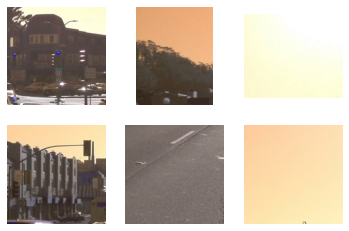

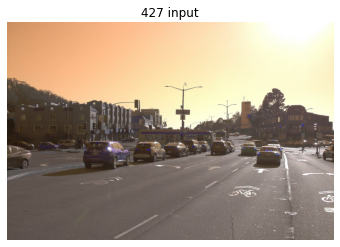

428 : (1280, 1920, 3)


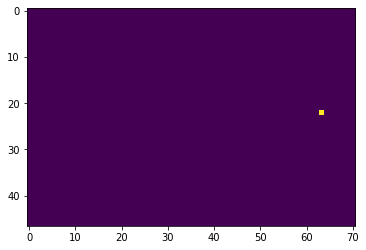

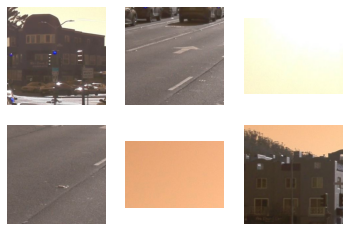

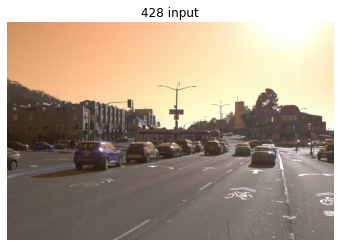

429 : (1280, 1920, 3)


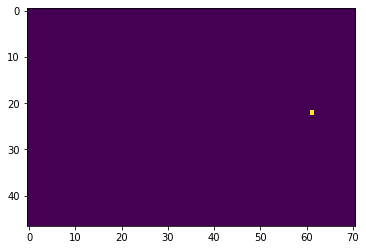

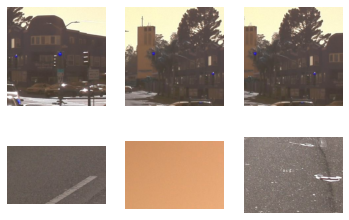

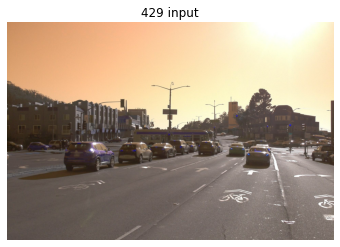

In [46]:
while f < 430:
    input_image = imread(path + str(f).zfill(15) + '.jpg')
    print(str(f) + " :", input_image.shape)
    input_image = np.expand_dims(input_image, axis=0)
    low, patches, sampled_attention, samples, ats_map, p_features, expected, y_pred = ats_model.predict(input_image)
    crops = []
    sample_lts = []
    sample_rbs = []
    plt.imshow(ats_map[0])
    plt.show()
    # print(samples[0])
    for sample in samples[0]:
        # print(sample)
        cropped, lt, rb = neighPatches(sample, opts.patch_size, input_image[0])
        sample_lts.append(lt)
        sample_rbs.append(rb)
        crops.append(cropped)
    # print(np.array(crops).shape)
    show_patches(crops, (2, 3))
    plt.imshow(input_image[0])
    plt.axis("off")
    plt.title(str(f)+" input")
    plt.show()
    f += 1